# Cantilever beam physics-informed neural network (PINN)

## Problem overview

The example problem we solve here is a continuous beam:
$$ \rho A \frac{\partial^2w}{\partial t^2} + E I \frac{\partial^4w}{\partial x^4} + \rho A c \frac{\partial w}{\partial t} = f(t) $$
$$ w(x, t) = \sum_{j=1}^{\infty}\varphi_j(x)q_j(t) \approx \sum_{j=1}^{n}\varphi_j(x)q_j(t) $$
where $\varphi_j$ and $q_j$ are the $j^{th}$ modal shape and coordinate of the $j^{th}$ mode, respectively.
$$
\mathbf{M}\ddot{\mathbf{q}}(t) + \mathbf{C}\dot{\mathbf{q}}(t) + \mathbf{K}\mathbf{q}(t) = \mathbf{S_p}\mathbf{p}(t)
$$
where,
$$
\mathbf{M} = \rho A \int_0^l\mathbf{\psi}(x)\mathbf{\psi}^T(x) dx, \qquad
\mathbf{C} = \rho Ac \int_0^l\mathbf{\psi}(x)\mathbf{\psi}^T(x) dx, \qquad
\mathbf{K} = EI \int_0^l\mathbf{\psi}(x){\mathbf{\psi}''''}^T(x) dx
$$
in the state space,
$$
\dot{\mathbf{\tau}}(t) = \mathbf{A} \mathbf{\tau}(t) + \mathbf{H} \mathbf{f}(t)
$$
where,
$$
\mathbf{\tau} = \begin{bmatrix} \mathbf{q}(t) \\ \dot{\mathbf{q}}(t) \end{bmatrix}, \qquad
\mathbf{A} = \begin{bmatrix} 0 & \mathbf{I} \\ -\mathbf{M}^{-1}\mathbf{K} & -\mathbf{M}^{-1}\mathbf{C} \end{bmatrix}, \qquad
\mathbf{H} = \begin{bmatrix} 0 \\ \mathbf{M}^{-1} \end{bmatrix}, \qquad
\mathbf{f}(t) = m_e g\mathbf{\Psi}(x_e)\mathbf{I}
$$
And the measurement vector is,
$$ \mathbf{y}(t) = \begin{bmatrix} S_d & 0 \\ 0 & S_a \end{bmatrix} \begin{bmatrix} \mathbf{q}(t) \\ \ddot{\mathbf{q}}(t) \end{bmatrix} $$

<!-- $$
\mathrm{argmin}\mathcal{L}(\mathbf{x},t;\mathbf{\theta}) := \mathcal{L}_a + \lambda\left[ \mathcal{L}_{ode} \right]
$$
$$
\mathcal{L}_a = \langle \varphi_{kj}\hat{q}_j - y_k^* \rangle
$$
$$
\mathcal{L}_{ode,j} = \langle \hat{\ddot{q}}_j + 2\hat{\zeta}\hat{\omega}_j\hat{\dot{q}}_j + \hat{\omega}^2\hat{q}_j - p^*_j \rangle, \qquad
\mathcal{L}_{ode,j} = \langle \hat{m} \partial^2_{\hat{t}}\mathcal{N}_{\hat{q}} + \hat{c} \partial_{\hat{t}}\mathcal{N}_{\hat{x}} + \hat{k}\mathcal{N}_{\hat{x}} \rangle _{\Omega_d}
$$
where,
$$ \mathcal{N}_{\bullet} = \mathcal{N}_{\bullet}(\mathbf{x};\mathbf{\theta}), \qquad 
\partial_{*}\bullet = \frac{\partial\bullet}{\partial *}, \qquad 
\partial^2_{*}\bullet = \frac{\partial^2\bullet}{\partial *^2}, \qquad
\langle\bullet\rangle _{\Omega_{\kappa}} = \frac{1}{N_{\kappa}}\sum_{x\in\Omega_{\kappa}}\left|\left|\bullet\right|\right|^2 $$

ODE loss function comes from including the normalisation of the parameters, then choosing the suitable range to aid optimisation.

$$
\frac{1}{\alpha_t^2} \partial^2_{\hat{t}}\hat{q} + \tilde{c}\frac{1}{\alpha_t}\partial_{\hat{t}}\hat{q} + \tilde{k} \hat{q} = 0, \qquad \hat{m} \partial^2_{\hat{t}}\hat{q} + \hat{c} \partial_{\hat{t}}\hat{q} + \hat{k}\hat{q} = 0
$$
> trad(itional)
$$
\hat{m} = \frac{1}{\alpha_t^2}, \quad \hat{c} = \tilde{c}\frac{1}{\alpha_t}, \quad \hat{k} = \tilde{k}
$$
> up_time
$$
\hat{m} = \frac{1}{\alpha_t}, \quad \hat{c} = \tilde{c}, \quad \hat{k} = \tilde{k}\alpha_t
$$
> up_time2
$$
\hat{m} = 1, \quad \hat{c} = \tilde{c}\alpha_t, \quad \hat{k} = \tilde{k}\alpha_t^2
$$ -->

In [46]:
from osa_beam_pinn import osa_pinn_beam_vel_2, normalise
from beam_solutions import cont_beam
from math import pi

from datetime import datetime
import pickle

import numpy as np
import torch
import torch.nn as nn
device = torch.device("mps")

from tqdm import tqdm
from tqdm.auto import tqdm as tqdma

import matplotlib.pyplot as plt
from matplotlib import cm
from IPython import display
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Auxiliary functions

In [47]:
def gen_beam_params(E, rho, EI, pA):
    I_ = EI/E
    A_ = pA/rho
    h = (2*I_/A_)**(0.5)
    b = A_/h
    I = (1/12) * b * h**3
    A = b * h
    return I, A, b, h

def plot_vib_surface(ax, x, time, w, sub_samp=10):
    if len(x.shape) == 1 and len(time.shape) == 1:
        xx, tt = torch.meshgrid(x[::sub_samp], time[::sub_samp], indexing="ij")
        x_ = unroll_mat(xx)
        time_ = unroll_mat(tt)
    else:
        if x.shape[1] > 1 and time.shape[1] > 1:
            x_ = unroll_mat(x[::sub_samp,:][:,::sub_samp])
            time_ = unroll_mat(time[::sub_samp,:][:,::sub_samp])
        elif x.shape[1] <= 1 and time.shape[1] <= 1:
            xx, tt = torch.meshgrid(x[::sub_samp], time[::sub_samp], indexing="ij")
            x_ = unroll_mat(xx)
            time_ = unroll_mat(tt)
    if len(w.shape) == 1:
        w_ = w[::sub_samp]
    else:
        if w.shape[1] > 1:
            w_ = unroll_mat(w[::sub_samp,:][:,::sub_samp])
        else:
            w_ = w[::sub_samp]

    ax.plot_trisurf(x_, time_, w_, cmap=cm.plasma, linewidth=0.1, edgecolor='black')
    ax.set_xlabel('x, m')
    ax.set_ylabel('Time, s')
    ax.set_zlabel('w, m')

def plot_vib_scatter(ax, x, time, w, color='grey'):
    ax.scatter3D(x, time, w, color=color)
    ax.set_xlabel('x, m')
    ax.set_ylabel('Time, s')
    ax.set_zlabel('w, m')

def unroll_mat(data):
    nn = data.shape[0]*data.shape[1]
    data_ = torch.zeros(nn)
    di = 0
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            data_[di] = data[i,j]
            di += 1
    return data_

def roll_mat(data, n1, n2):
    data_ = torch.zeros((n1, n2))
    d_count = 0
    for i in range(n1):
        for j in range(n2):
            data_[i, j] = data[d_count]
            d_count += 1
    return data_

## Generate training data

In [48]:
# get the analytical solution over the full domain
E = 1e7
rho = 2700
EI_ = 5e-3
pA = 1.0
c = 0.0
l = 1.0
w1 = (pi**2) * ((EI_)/(pA*(l**4)))**0.5
f1 = w1/(2*pi)
I, A, b, h = gen_beam_params(E, rho, EI_, pA)

nx = 128
nt = 64
n_modes = 6

beam_kwargs_sep = {
    "E" : E,
    "I" : I,
    "rho" : rho,
    "A" : A,
    "l" : l
}

beam_kwargs_cmb = {
    "EI" : EI_,
    "pA" : pA,
    "l" : l
}

# ss_beam = cont_beam("sep_vars", beam_kwargs_sep)
ss_beam = cont_beam("cmb_vars", **beam_kwargs_cmb)
ss_beam.gen_modes("ss-ss", n_modes, nx)

xx = ss_beam.xx

In [49]:
f0 = 1
init_disp = 0.1
v0 = 0.0
vv0 = torch.zeros(nx)

t = torch.linspace(0,2.5,nt)

# init_load = {
#     "type" : "point_load",
#     "f0" : f0,
#     "load_coord" : 0.1,
# }
# w0 = ss_beam.init_cond_load(init_load)
# wxt, wxt_n = ss_beam.free_vibration(t, w0, vv0, 0.0)

# forcing = {
#     "type" : "step_load",
#     "force_mag" : f0,
#     "load_coord" : 0.1
# }
# forcing = {
#     "type" : "harmonic",
#     "force_mag" : f0,
#     "load_coord" : 0.1,
#     "frequency" : 0.8
# }
# wxt, wxt_n = ss_beam.forced_vibration(t, forcing)

# init_disp_loc = 0.1
# init_disp_id = torch.argmin(torch.abs(ss_beam.xx - init_disp_loc))
# w0 = torch.zeros(nx)
# w0[init_disp_id] = init_disp
w0_func = lambda x : init_disp * torch.sin(3*pi*x)
w0 = w0_func(ss_beam.xx)
# wxt, wxtd, wxtdd, wxt_n = ss_beam.free_vibration(t, w0, vv0)

xx_g, tt = torch.meshgrid((ss_beam.xx, t), indexing="ij")
omega3 = 9*(pi**2) * (EI_/pA)**(0.5)
wxt = init_disp * torch.sin(3*pi*xx_g)*torch.cos(omega3*tt)

wxtd = init_disp * -omega3*torch.sin(3*pi*xx_g)*torch.sin(omega3*tt)
wxtdd = init_disp * -(omega3**2)*torch.sin(3*pi*xx_g)*torch.cos(omega3*tt)

wxdt = init_disp * 3*pi*torch.cos(3*pi*xx_g)*torch.cos(omega3*tt)
wxddt = init_disp * -9*(pi**2)*torch.sin(3*pi*xx_g)*torch.cos(omega3*tt)

Text(0.5, 1.0, 'Acceleration')

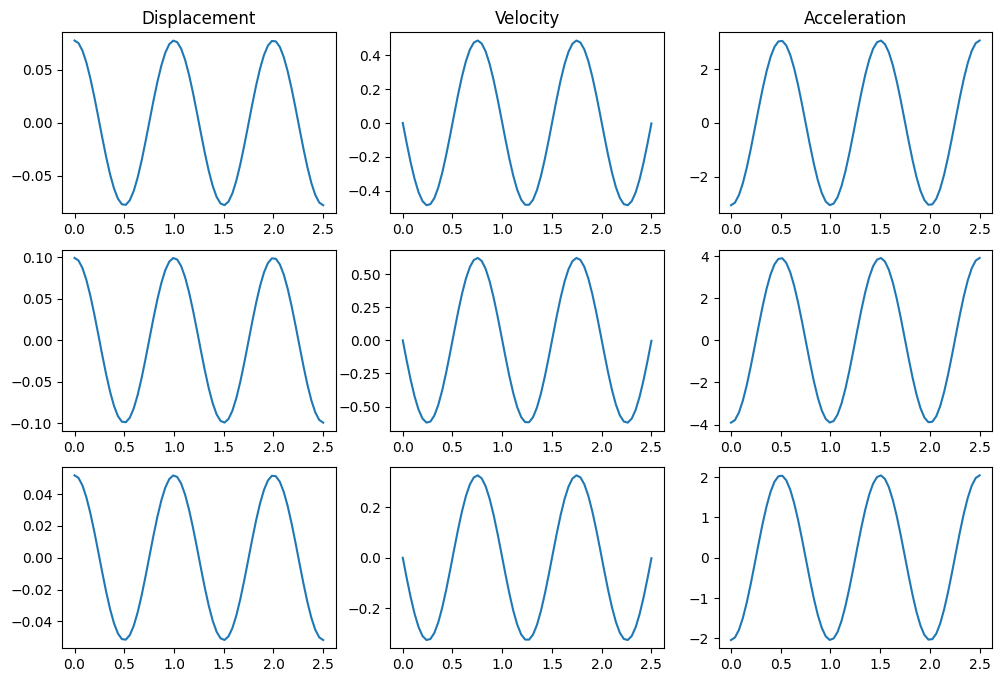

In [50]:
n_sens = 10
sens_distance = xx[-1]/(n_sens+1)  # distance between sensors
s_locs = np.arange(sens_distance, xx[-1], sens_distance)  # target location of sensors
s_ids = [np.argmin(np.abs(xx - s_locs[i])) for i in range(n_sens)]
# s_ids = s_ids[:-int(n_sens/2)]

plot_locs = [0.3, 0.45, 0.80]  # target location for plotting
plot_ids_ss = [np.argmin(np.abs(xx[np.array(s_ids)] - plot_locs[i])) for i in range(3)]  # plotting location ids, relative to sensor dataset
plot_locs_ = [xx[s_ids[k]] for k in plot_ids_ss]
plot_ids_gt = [np.argmin(np.abs(xx - plot_locs_[i])) for i in range(3)]  # plotting location ids, relative to gt dataset, by taking closest of sensor dataset

fig, axs = plt.subplots(3, 3, figsize = (12,8))
for i in range(3):
    axs[i,0].plot(t, wxt[s_ids[i],:])
    axs[i,1].plot(t, wxtd[s_ids[i],:])
    axs[i,2].plot(t, wxtdd[s_ids[i],:])
axs[0,0].set_title('Displacement')
axs[0,1].set_title('Velocity')
axs[0,2].set_title('Acceleration')

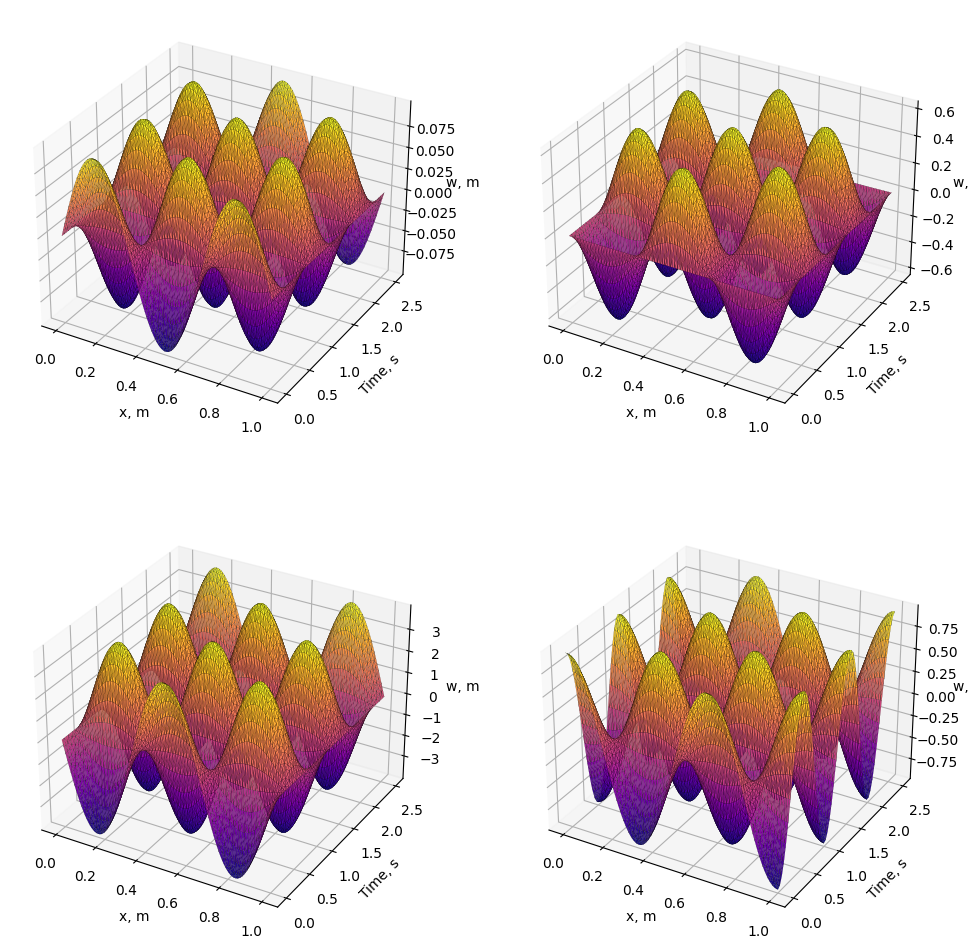

In [51]:
fig, axs = plt.subplots(2, 2, subplot_kw = {"projection":"3d"}, figsize=(12,12))
axs = axs.ravel()
plot_vib_surface(axs[0], xx, t, wxt, 1)
plot_vib_surface(axs[1], xx, t, wxtd, 1)
plot_vib_surface(axs[2], xx, t, wxtdd, 1)
plot_vib_surface(axs[3], xx, t, wxdt, 1)

Normalise

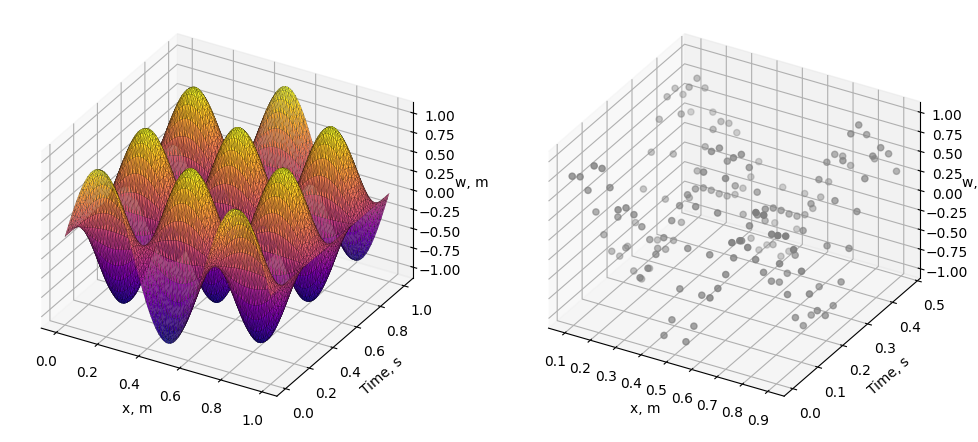

In [52]:
t_hat, alpha_t = normalise(t, "range")
x_hat, alpha_x = normalise(xx, "range")
w_hat, alpha_w = normalise(wxt, "range", "all")
wd_hat, alpha_wd = normalise(wxtd, "range", "all")

alphas = {
    "x" : alpha_x,
    "t" : alpha_t,
    "w" : alpha_w,
    "wd" : alpha_wd,
    "pA" : pA*10,
    "EI" : EI_*10
}

ground_truth = {
    "w_hat" : w_hat,
    "x_hat" : x_hat,
    "t_hat" : t_hat
}

sub_ind_x = torch.tensor(s_ids)  # indices for sub-selection along x (sensor data)
sub_ind_t = np.arange(0, int(nt/4), 2)  # indices for sub-selection along time

x_data_vec = x_hat[sub_ind_x]  # vector of x data of sensors (observations)
L = x_data_vec[1] - x_data_vec[0]

t_data_vec = t_hat[sub_ind_t]  # vector of time data of sensors (observations)
T_hat = t_data_vec[1] - t_data_vec[0]  # horizon window (normalised)
T = T_hat * alpha_t  # horizon window (unnormalised)

w_data_mat = w_hat[:, sub_ind_t][sub_ind_x, :]
wd_data_mat = wd_hat[:, sub_ind_t][sub_ind_x, :]

data = {
    "w_hat" : w_data_mat,
    "x_hat" : x_data_vec,
    "t_hat" : t_data_vec
}

sens_ids_ = [torch.argmin(torch.abs(x_data_vec - s_locs[i]/alpha_x)) for i in range(3)]

x_data = x_data_vec.view(-1,1).repeat(1,t_data_vec.shape[0])
t_data = t_data_vec.view(-1,1).repeat(1,x_data_vec.shape[0]).T

fig, axs = plt.subplots(1, 2, subplot_kw = {"projection":"3d", "proj_type":"ortho"}, figsize=(12,12))
plot_vib_surface(axs[0], x_hat, t_hat, w_hat, 1)

# plot_vib_surface(axs[1], x_data_vec, t_data_vec, w_data_mat, 1)
plot_vib_scatter(axs[1], x_data, t_data, w_data_mat)

In [53]:
def plot_nn_update(axs_m, ground_truth, data, prediction, alphas):
    axs = [axs_m["A"], axs_m["B"], axs_m["C"]]
    for ax in axs:
        ax.cla()
    xL = torch.amax(t_hat)*alphas["t"]
    for i in range(2):
        axs[i].plot(ground_truth["t_hat"]*alphas["t"], ground_truth["w_hat"][s_ids[i],:]*alphas["w"], color="grey", linewidth=1.5, alpha=0.8, label="Ground Truth")
        axs[i].plot(prediction["t_hat"]*alphas["t"], prediction["w_hat"][plot_ids_pred[i],:]*alphas["w"], color="tab:blue", linewidth=1, alpha=0.8, label="Neural network prediction")
        axs[i].scatter(data["t_hat"]*alphas["t"], data["w_hat"][i,:]*alphas["w"], s=60, color="tab:orange", alpha=0.4, label='Training data')
        yL = torch.amax(torch.abs(ground_truth["w_hat"][s_ids[i],:]))*alphas["w"]
        axs[i].set_xlim(-0.05*xL, 1.05*xL)
        axs[i].set_ylim(-1.1*yL, 1.1*yL)
        axs[i].legend()
    
    axs[2].plot(prediction["x_hat"]*alphas["x"], prediction["w_hat"][:,0]*alphas["w"], color="tab:blue", linewidth=1, alpha=0.8, label="Neural network prediction")
    axs[2].plot(beam_osa_model.x_pred[beam_osa_model.true_ic_ids]*alphas["x"],beam_osa_model.true_ic*alphas["w"], color="tab:red")
    axs[2].scatter(data["x_hat"]*alphas["x"], data["w_hat"][:,0]*alphas["w"], s=60, color="tab:orange", alpha=0.4, label='Training data')
    yL = torch.amax(torch.abs(ground_truth["w_hat"][s_ids[i],:]))*alphas["w"]
    axs[2].set_xlim(-0.05, 1.05)
    axs[2].set_ylim(-1.1*yL, 1.1*yL)
    axs[2].legend()

    axs_m['E'].cla()
    plot_vib_surface(axs_m['E'], prediction["x_hat"]*alphas["x"], prediction["t_hat"]*alphas["t"], prediction["w_hat"]*alphas["w"], 1)
    plot_vib_scatter(axs_m['E'], x_data*alphas["x"], t_data*alphas["t"], w_data_mat*alphas["w"])
    axs_m['E'].plot(beam_osa_model.x_pred[beam_osa_model.true_ic_ids]*alphas["x"],
                    beam_osa_model.t_pred[beam_osa_model.true_ic_ids]*alphas["t"],
                    beam_osa_model.true_ic*alphas["w"], color="tab:red")

def plot_loss_hist(ax,loss_hist):
    n_epoch = len(loss_hist)
    ax.cla()
    loss_labs = ['Observation loss', 'Physics loss', 'TIC loss', 'IC loss', 'BC loss', 'CC loss', 'Total loss']
    loss_cols = ['b', 'r', 'g', 'm', 'c', 'tab:orange', 'k']
    for i in range(loss_hist.shape[1]):
        ax.plot(np.arange(1,n_epoch+1), loss_hist[:,i], loss_cols[i], label=loss_labs[i])
    ax.set_yscale('log')
    ax.set_ylim((1e-2,1e5))
    ax.legend()

def print_inter():

    wpred_vec = beam_osa_model.predict().detach()

    wpred = wpred_vec.reshape(beam_osa_model.n_col_x, beam_osa_model.n_col_t)
    prediction["w_hat"] = wpred

    plot_nn_update(axs, ground_truth, data, prediction, alphas)

    plot_loss_hist(axs["D"],np.array(loss_hist))
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    match beam_osa_model.param_type:
        case "constant":
            tqdma.write("Epoch : %d ---- Loss: %.2e" % (i+1,loss_hist[i][-1]))
        case "variable":
            tqdma.write("Epoch : %d ---- Loss: %.2e \npA: %.4f ---- EI: %.4f" % (i+1, loss_hist[i][-1], beam_osa_model.params[0]*alphas['pA'], beam_osa_model.params[1]*alphas['EI']))

## PINN
Some shorthand definitions,
$$ \mathcal{N}_{\bullet} = \mathcal{N}_{\bullet}(\mathbf{x};\mathbf{\theta}), \qquad 
\partial_{*}\bullet = \frac{\partial\bullet}{\partial *}, \qquad 
\partial^n_{*}\bullet = \frac{\partial^n\bullet}{\partial *^2}, \qquad
\langle\bullet\rangle _{\Omega_{\kappa}} = \frac{1}{N_{\kappa}}\sum_{x\in\Omega_{\kappa}}\left|\left|\bullet\right|\right|^2 $$

Defined as function of initial displacement, velocity, location, and time:
$$
\mathbf{x} = \{x, t, w_0, \ddot{w}_0\} \quad \rightarrow \quad \mathcal{N}(x, t, w_0, \ddot{w}_0;\mathbf{\theta})
$$

$$
\mathrm{argmin}L(\mathbf{x},t;\mathbf{\theta}) := \lambda_0L_{obs} + \lambda_1 L_{bc} + \lambda_2 L_{ic} + \lambda_3 L_{pde}
$$
Observations:
$$
L_{obs} = \langle \hat{w} - \mathcal{N}_w \rangle _{\Omega_{t=T}}
$$
Boundary conditions:
$$
L_{bc} = \langle \mathcal{N}_w \rangle _{\Omega_{bc}}, \qquad \Omega_{bc} \in x=\{0.0,l\}
$$
Initial conditions:
$$
L_{ic} = \left[ \langle \dot{w}_0 - \partial_t\mathcal{N}_{w} \rangle + \langle w_0 - \mathcal{N}_{w} \rangle\right]_{\Omega_{t=0}}
$$
Partial differential equation:
$$
L_{pde} = \langle \rho A \partial_t^2 \mathcal{N}_w + EI \partial_x^4\mathcal{N}_w \rangle _{\Omega_d}, \qquad \Omega_d \in x=0,...,T
% \qquad
% L_{pde} = \langle \hat{m} \partial_t^2 \mathcal{N}_w + \hat{k} \partial_x^4\mathcal{N}_w \rangle
$$

ODE loss function comes from including the normalisation of the parameters, then choosing the suitable range to aid optimisation.
$$
\frac{\rho A}{\alpha_t^2} \partial^2_{\hat{t}}\hat{w} + \frac{EI}{\alpha_x^4} \partial_{\hat{x}}^4 \hat{w} = 0, \quad \rightarrow \quad 
\hat{m} \partial^2_{\hat{t}}\hat{w} + \hat{k}\partial_{\hat{x}}^4\hat{w} = 0
$$

$$
\hat{m} = \frac{\rho A}{\alpha_t^2}, \quad \hat{k} = \frac{EI}{\alpha_x^4}
$$

To scale loss function in a physically meaningful way, multiply $\hat{m}$, $\hat{c}$, and $\hat{k}$ by any (or combination) of the following:
$$
\Lambda = \alpha_t,~~\alpha_t^2,~~\alpha_x,~~\alpha_x^2,~~\alpha_x^3,~~\alpha_x^4
$$

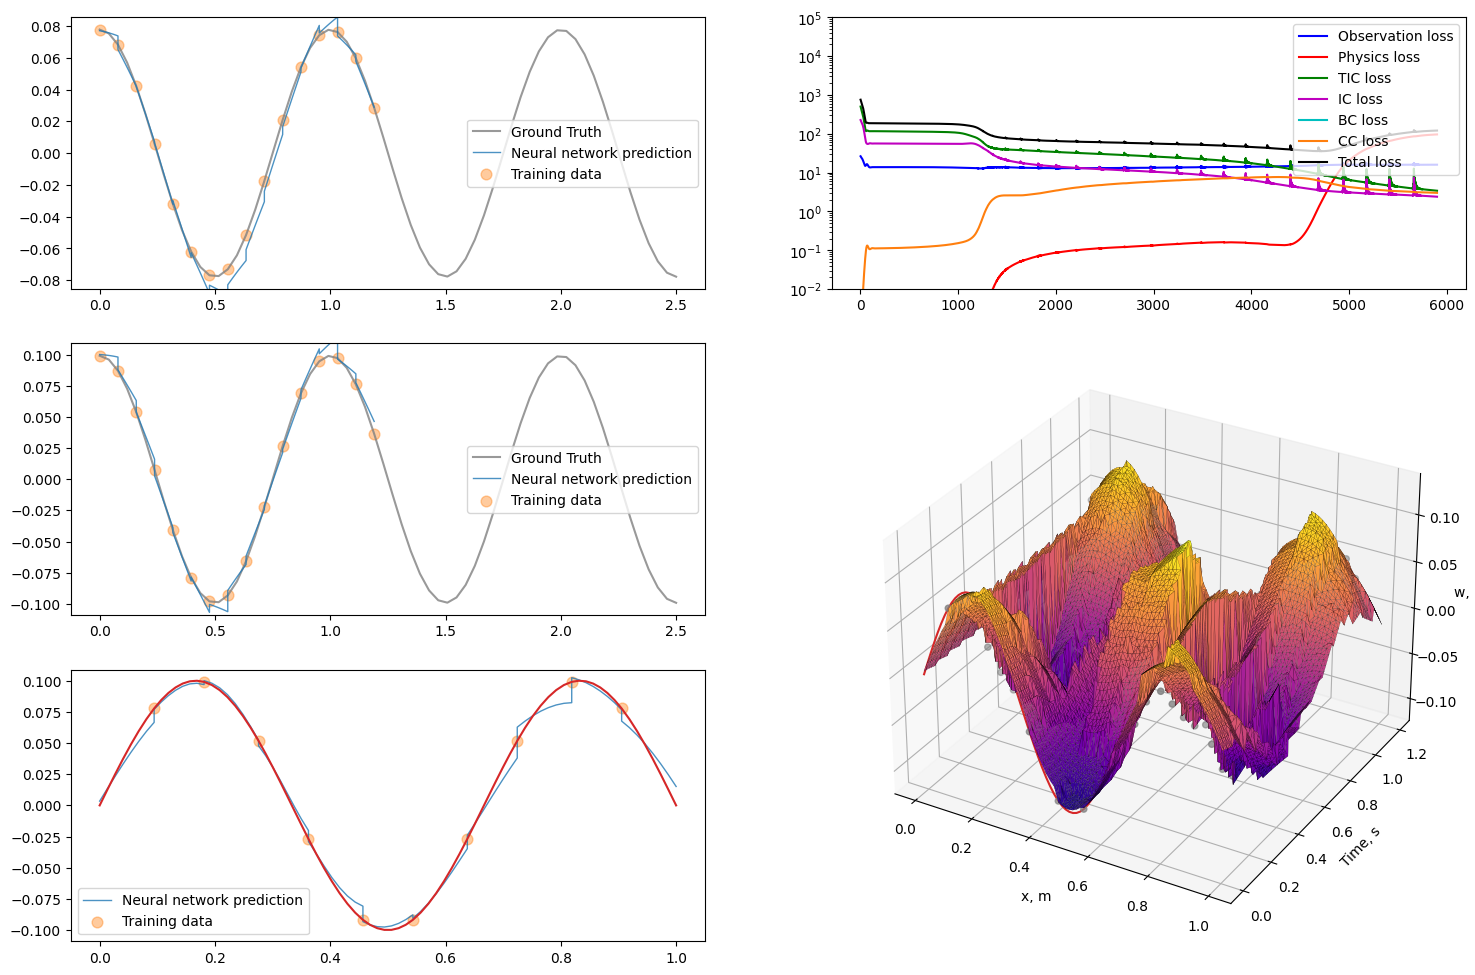

  1%|          | 5901/500000 [16:27<162:12:30,  1.18s/it]

Epoch : 5900 ---- Loss: 1.21e+02


  1%|          | 5992/500000 [16:56<25:36:09,  5.36it/s] 

In [73]:
torch.manual_seed(43810)

osa_config = {
    "n_input" : 5,
    "n_output" : 1,
    "n_hidden" : 64,
    "n_layers" : 4,
    "l" : l,
    "L" : L,
    "ncx" : 8,
    "T" : T,
    "T_hat" : T_hat,
    "nct" : 8,
    "phys_params" : {
        "par_type" : "constant",
        "pA" : pA,
        "EI" : EI_
    },
    "alphas" : alphas,
    "pde_norm_Lambda" : 1.0,
    "ic_func" : w0_func
}

# configure PINN
beam_osa_model = osa_pinn_beam_vel_2(osa_config)
x_pred, t_pred = beam_osa_model.set_colls_and_obs(t_data, x_data, w_data_mat, wd_data_mat)
prediction = {
    "x_hat" : x_pred[:,0],
    "t_hat" : t_pred[0,:]
}
plot_ids_pred = []
for i in range(len(s_ids)):
    plot_id1 = torch.argwhere(x_pred[:,0]==xx[s_ids[i]])
    plot_ids_pred.append(plot_id1[-1].item())
# plot_ids_pred = torch.argwhere()

# beam_osa_model = beam_osa_model.to(device)

# configure optimiser
epochs = int(500e3)
learning_rate = 2e-4
betas = (0.9,0.999)
optimizer = torch.optim.Adam(beam_osa_model.parameters(), lr=learning_rate, betas=betas)
# epochs = int(50e3)
# learning_rate = 5e-3
# optimizer = torch.optim.LBFGS(beam_osa_model.parameters(), lr=learning_rate, max_eval=20)

lambds = {
    'obs' : 1000.0,
    'bc' : 00.0,
    'ic' : 600.0,
    'tic' : 1000.0,
    'pde' : 0.01,
    'cc' : [1.0, 1.0],
    # 'cc' : [0.0, 0.0]
    }

fig, axs = plt.subplot_mosaic(
    "AD;BE;CE",
    per_subplot_kw = {
    "E" : {"projection" : "3d"}
    },
    figsize=(18,12), 
    facecolor='w'
    )
loss_hist=[]
print_step = 100
beam_osa_model.set_loss_switches(lambds)

for i in tqdm(range(epochs)):

    # def closure():
    #     optimizer.zero_grad()
    #     loss, losses = beam_osa_model.loss_func(lambds)
    #     loss_hist.append([loss_it.item() for loss_it in losses] + [loss.item()])
    #     loss.backward()
    #     return loss
    
    # optimizer.step(closure)

    optimizer.zero_grad()
    loss, losses = beam_osa_model.loss_func(lambds)
    loss_hist.append([loss_it.item() for loss_it in losses] + [loss.item()])
    loss.backward()
    optimizer.step()

    if (i+1) % print_step == 0:
        print_inter()

display.clear_output()
match beam_osa_model.param_type:
    case "constant":
        tqdma.write("Epoch : %d ---- Loss: %.2e" % (i+1,loss_hist[i][-1]))
    case "variable":
        tqdma.write("Epoch : %d ---- Loss: %.2e \npA: %.4f ---- EI: %.4f" % (i+1, loss_hist[i][-1], beam_osa_model.params[0]*alphas['pA'], beam_osa_model.params[1]*alphas['EI']))

In [ ]:
del osa_config['ic_func']

checkpoint = {
    'epoch' : i,
    'model' : beam_osa_model.state_dict(),
    'optimizer' : optimizer.state_dict(),
    'loss' : loss_hist,
    "beam_config" : beam_kwargs_sep,
    "pinn_config" : osa_config
}

now = datetime.now()
timestamp = now.strftime("%H_%M_%S_%d_%m_%Y")

torch.save(checkpoint,('checkpoints/beam_osa_'+timestamp+'.pth'))

  0%|          | 899/500000 [06:25<59:30:36,  2.33it/s]


KeyboardInterrupt: 

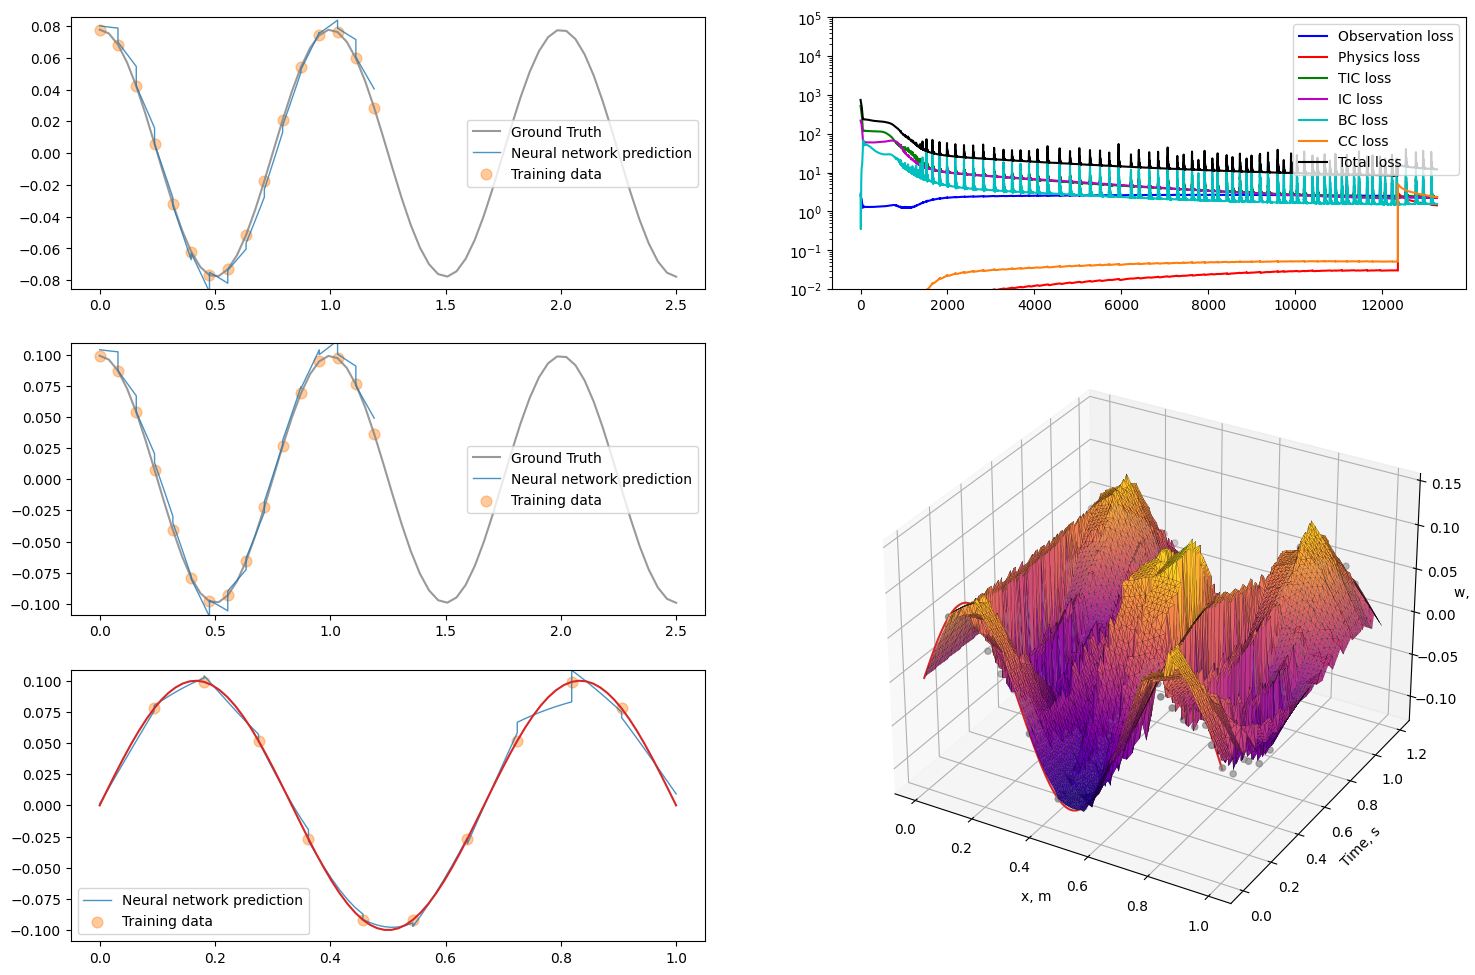

In [ ]:
osa_config['ic_func'] = w0_func
beam_osa_model = osa_pinn_beam_vel_2(osa_config)
x_pred, t_pred = beam_osa_model.set_colls_and_obs(t_data, x_data, w_data_mat, wd_data_mat)
plot_ids_pred = []
for i in range(len(s_ids)):
    plot_id1 = torch.argwhere(x_pred[:,0]==xx[s_ids[i]])
    plot_ids_pred.append(plot_id1[-1].item())

timestamp = '13_26_28_11_05_2023'
checkpoint = torch.load(('checkpoints/beam_osa_'+timestamp+'.pth'))
loss_hist = checkpoint['loss']
# loss_hist = []
beam_osa_model.load_state_dict(checkpoint['model'])
epochs = int(500e3)
learning_rate = 5e-4
betas = (0.9,0.999)
optimizer = torch.optim.Adam(beam_osa_model.parameters(), lr=learning_rate, betas=betas)
optimizer.load_state_dict(checkpoint['optimizer'])

for g in optimizer.param_groups:
    g['lr'] = 5e-4

lambds = {
    'obs' : 10.0,
    'bc' : 500.0,
    'ic' : 600.0,
    'tic' : 1000.0,
    'pde' : 0.01,
    'cc' : [1e-2, 1e-2],
    # 'cc' : [0.0, 0.0]
    }

fig, axs = plt.subplot_mosaic(
    "AD;BE;CE",
    per_subplot_kw = {
    "E" : {"projection" : "3d"}
    },
    figsize=(18,12), 
    facecolor='w'
    )

print_step = 100
beam_osa_model.set_loss_switches(lambds)

for i in tqdm(range(epochs)):

    optimizer.zero_grad()
    loss, losses = beam_osa_model.loss_func(lambds)
    loss_hist.append([loss_it.item() for loss_it in losses] + [loss.item()])
    loss.backward()
    optimizer.step()

    if (i+1) % print_step == 0:
        print_inter()

display.clear_output()
match beam_osa_model.param_type:
    case "constant":
        tqdma.write("Epoch : %d ---- Loss: %.2e" % (i+1,loss_hist[i][-1]))
    case "variable":
        tqdma.write("Epoch : %d ---- Loss: %.2e \npA: %.4f ---- EI: %.4f" % (i+1, loss_hist[i][-1], beam_osa_model.params[0]*alphas['pA'], beam_osa_model.params[1]*alphas['EI']))